In [ ]:
from pyhive import presto
from sqlalchemy import create_engine
from string import Template

class DataHandler:

    def __init__(self, params):
        self.params = params
        self.market = params['market']
        self.cnxn = self.connect_to_presto()
        self.engine = create_engine(f"presto://presto-{self.market}.taxibeat.com:8080/")

    def connect_to_presto(self):
        """
        Function to initialize connection with Presto database
        """
        try:
            cnxn = presto.connect(host=f"presto-{self.market}.taxibeat.com", port=8080)
        except presto.DatabaseError as err:
            print(f"Error: Could not make connection to Presto DB: {err}")
        return cnxn

    def execute_query(self, query):
        df = pd.read_sql_query(query, self.cnxn)
        return df
    
    def read_query(self, path):
        with open(path, "r") as f:
            query = f.read()
        return query
    
    def transform_query(self, query):
        query = Template(query)
        transformed_query = query.substitute(self.params)
        return transformed_query

    def drop_table(self, table_name):
        query = f"DROP TABLE IF EXISTS {table_name}"
        pd.read_sql_query(query, self.cnxn)

    def store_data(self, table_name, df, mode='replace'):
        df.to_sql(
            name=table_name,
            con=self.engine,
            if_exists=mode,
            index=False,
            chunksize=10000,
            method='multi'
        )
        
        
params={"country": "colombia",
        "market": "co"}

d = DataHandler(params)

df = d.execute_query(""" select * from
co.dna.underestimated_rides_raw_level_data limit 2000000
""")

In [1]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}

def integer_encode(df, variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)
    
def calculate_top_categories(df, variable, n=10):
    return [x for x in df[variable].value_counts().sort_values(ascending=False).head(n).index]

def one_hot_encode(df, variable, top_labels):
    for label in top_labels:
        df[variable + '_' + label] = np.where(df[variable] == label, 1, 0)
        
def frequency_encoding(df,variable):
    count_map = df[variable].value_counts().to_dict()
    df[variable + '_' + 'freq_encoding'] = df[variable].map(count_map) / len(df)
    
def find_freq_labels(data, variable, upper_tolerance, lower_tolerance):
    
    temp = data.groupby([variable])[variable].count() / len(data)
    
    high_freq = [x for x in temp.loc[temp>upper_tolerance].index.values]
    med_freq = [x for x in temp.loc[(temp>lower_tolerance) & (temp<upper_tolerance)].index.values]
    rare_freq = [x for x in temp.loc[temp<lower_tolerance].index.values]
    
    return high_freq, med_freq, rare_freq

def discretize(data, var, num_of_bins):
    disc, intervals = pd.qcut(
    data[var], num_of_bins, labels=['Q'+str(i) for i in range(1,num_of_bins+1)], 
    retbins=True, precision=3, duplicates='raise')

    data[var+'_discretized'] = disc
    
def remove_outlier(df, col_name, multiplier=1.5):
    q1 = df[col_name].quantile(0.05)
    q3 = df[col_name].quantile(0.95)
    iqr = q3 - q1 #Interquartile Range
    low_bound  = q1 - multiplier * iqr
    high_bound = q3 + multiplier * iqr
    df_out = df.loc[(df[col_name] > low_bound) & (df[col_name] < high_bound)]
    
    return df_out

def stratify_data(df_data, stratify_column_name, stratify_values, stratify_proportions, random_state=None):
    """Stratifies data according to the values and proportions passed in
    Args:
        df_data (DataFrame): source data
        stratify_column_name (str): The name of the single column in the dataframe that holds the data values that will be used           to stratify the data
        stratify_values (list of str): A list of all of the potential values for stratifying e.g. "Train, Validate", "Test"
        stratify_proportions (list of float): A list of numbers representing the desired propotions for stratifying e.g. 0.4,             0.4, 0.2. The list values must add up to 1 and must match the number of values in stratify_values
        random_state (int, optional): sets the random_state. Defaults to None.
    Returns:
        DataFrame: a new dataframe based on df_data that has the new proportions represnting the desired strategy for stratifying
    """
    df_stratified = pd.DataFrame(columns = df_data.columns) # Create an empty DataFrame with column names matching df_data
    pos = -1
    for i in range(len(stratify_values)): # iterate over the stratify values (e.g. Train, Validate, Test)
        pos += 1
        if pos == len(stratify_values) - 1:
            ratio_len = len(df_data) - len(df_stratified) # if this is the final iteration make sure we calculate the number of values for the last set such that the return data has the same number of rows as the source data
        else:
            ratio_len = int(len(df_data) * stratify_proportions[i]) # Calculate the number of rows to match the desired proportion
        df_filtered = df_data[df_data[stratify_column_name] ==stratify_values[i]] # Filter the source data based on the currently selected stratify value
        df_temp = df_filtered.sample(replace=True, n=ratio_len, random_state=random_state) # Sample the filtered data using the calculated ratio
        df_stratified = pd.concat([df_stratified, df_temp]) # Add the sampled / stratified datasets together to produce the final result
    
    return df_stratified # Return the stratified, re-sampled data

def equal_sampling (data, col, randomstate):
    k = data[col].value_counts().min()
    df = data.groupby(col).apply(lambda x: x.sample(k,random_state=randomstate)) 
    df.index = df.index.droplevel(0)
    
    return df

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

In [3]:
#df.to_csv('distanceestimation_co_2.csv')
df = pd.read_csv('distanceestimation_co_2.csv').sort_values('created_local')
df.distance_actual = df.distance_actual / 1000
del df['Unnamed: 0']

In [4]:
df = df[df.distance_actual>5]

In [5]:
# Basic Transformations - Not used as Features
df['timestamp'] = pd.to_datetime(df.created_local)
df['date'] = pd.to_datetime(df.created_local).dt.date
df['time'] = pd.to_datetime(df.created_local).dt.time

# Day and Time Features
df['hour'] = pd.to_datetime(df.created_local).dt.hour
df['minute'] = pd.to_datetime(df.created_local).dt.minute
df['weekday'] = pd.to_datetime(df.date).dt.weekday

# Basic Definition of error distance&duration-wise
df['dur_per_dist_est'] = df.estimate_duration/df.distance_est # Known value at the moment 
df['dur_per_dist_act'] = df.actual_duration_s/df.distance_actual # Known value at the end of the ride 

# Connecting Duration and Distance
df['dur_error'] = df.actual_duration_s/df.estimate_duration - 1
df['dist_error'] = df.distance_actual/df.distance_est - 1

# Definition of error based on the Duration per Distance (Km) ratio - Negative values imply underestimation
df['ratio_error'] = df.dur_per_dist_est/df.dur_per_dist_act - 1

In [6]:
df.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist_est', 'dur_per_dist_act', 'dur_error',
       'dist_error', 'ratio_error'],
      dtype='object')

In [7]:
# Create the categorical variable
#df['OnD'] = df.from_zone.astype('str') + '_' + df.to_zone.astype('str')
#frequency_encoding(df,'OnD')
#discretize(df,'OnD_freq_encoding',20)

df['origin'] = df.from_zone.astype('str')
df['destination'] = df.to_zone.astype('str')
frequency_encoding(df,'origin')
frequency_encoding(df,'destination')

#frequency_encoding(df,'id_driver')
#prone = df[df.target==1].groupby('id_driver')['id_city'].count().sort_values(ascending=False).head(30).index
#df['prone'] = np.where(df.id_driver.isin(list(prone)),1,0)

one_hot_encode(df,'service',df.service.unique())
one_hot_encode(df,'id_city',df.id_city.unique().astype('str'))
#one_hot_encode(df,'hour',df.hour.unique().astype('str'))

#top15_from_zones = calculate_top_categories(df,'from_zone',15)
#df['top_15_from_zone'] = np.where(df.from_zone.isin(top15_from_zones),1,0)
#top15_to_zones = calculate_top_categories(df,'to_zone',15)
#df['top_15_to_zone'] = np.where(df.to_zone.isin(top15_to_zones),1,0)

In [8]:
df

created_local  id_city    id_ride  id_driver  \
1384264  2022-03-01 00:00:08.000        3  154094913    1624663   
1108178  2022-03-01 00:00:19.000        1  154094916     230210   
1598940  2022-03-01 00:00:28.000        1  154094918     114767   
55866    2022-03-01 00:01:20.000        1  154094927     720921   
939198   2022-03-01 00:02:10.000        1  154094941    1405869   
...                          ...      ...        ...        ...   
741192   2022-06-30 18:53:39.000        1  163475059      41421   
1133263  2022-06-30 18:54:08.000        1  163475083     107006   
1943603  2022-06-30 18:54:23.000        3  163475104    1714219   
1680609  2022-06-30 18:54:26.000        1  163475107    1259336   
891754   2022-06-30 18:55:00.000        1  163475148    1717695   

         actual_duration_s  estimate_duration  distance_actual  distance_est  \
1384264                491                693         6.369902      6.820000   
1108178               1243               1042        13.614501     13.570000   
1598940                826                852         7.905441      7.920000   
55866                 1884               1876        23.028001     22.559999   
939198                 925                889        11.886213     12.120000   
...                    ...                ...              ...           ...   
741192                1535               1440         5.600658      5.780000   
1133263               2988               2472        11.473778     12.920000   
1943603               1917               1557         8.045535      8.490000   
1680609               1147               1238         8.566004      8.520000   
891754                1072               1059         5.699769      5.670000   

         base_fare service  ...  service_Lite service_Pronto service_Envío  \
1384264     8700.0    Beat  ...             0              0             0   
1108178    13600.0    Beat  ...             0              0             0   
1598940     9100.0    Beat  ...             0              0             0   
55866      21000.0    Beat  ...             0              0             0   
939198     11900.0    Beat  ...             0              0             0   
...            ...     ...  ...           ...            ...           ...   
741192      9700.0    Lite  ...             1              0             0   
1133263    16900.0    Lite  ...             1              0             0   
1943603    13200.0    Beat  ...             0              0             0   
1680609    11100.0    Lite  ...             1              0             0   
891754      9600.0    Beat  ...             0              0             0   

         service_Plus  service_Zero id_city_3 id_city_1 id_city_2  id_city_4  \
1384264             0             0         0         0         0          0   
1108178             0             0         0         0         0          0   
1598940             0             0         0         0         0          0   
55866               0             0         0         0         0          0   
939198              0             0         0         0         0          0   
...               ...           ...       ...       ...       ...        ...   
741192              0             0         0         0         0          0   
1133263             0             0         0         0         0          0   
1943603             0             0         0         0         0          0   
1680609             0             0         0         0         0          0   
891754              0             0         0         0         0          0   

         id_city_6  
1384264          0  
1108178          0  
1598940          0  
55866            0  
939198           0  
...            ...  
741192           0  
1133263          0  
1943603          0  
1680609          0  
891754           0  

[945307 rows x 41 columns]

In [9]:
#df['timestamp_shift'] = df['timestamp'].shift(-1)
#df['time_delta'] = (df.timestamp_shift - df.timestamp) / pd.Timedelta(minutes=1)
#del df['timestamp_shift']

In [10]:
# Target Variable on either Duration or Distance

#df['under_est_dur'] = np.where(df.dur_error > 0.08, 1, 0)
#df['under_est_dist'] = np.where(df.dist_error > 0.3, 1, 0)

# Target Variable on Duration per Km ratio 
df['target'] = np.where(df.ratio_error < -0.05, 1, 0)

### Get the last target values for drivers OnDs and Destinations

In [11]:
## For the Drivers

#last_drv_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('id_driver', keep='last')\
#                   [['id_driver','target']]
#df = df.merge(last_drv_target.set_index('id_driver'),on='id_driver',suffixes=(None,'_drv_last'))

## For the OnDs

#last_ond_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('OnD', keep='last')\
#                   [['OnD','target']]
#df = df.merge(last_ond_target.set_index('OnD'),on='OnD',suffixes=(None,'_ond_last'))

## For the Destinations

#last_dest_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('to_zone', keep='last')\
#                   [['to_zone','target']]
#df = df.merge(last_dest_target.set_index('to_zone'),on='to_zone',suffixes=(None,'_dest_last'))

## For the Origins

#last_orig_target = df.shift(-1).sort_values(by='created_local').drop_duplicates('from_zone', keep='last')\
#                   [['from_zone','target']]
#df = df.merge(last_orig_target.set_index('from_zone'),on='from_zone',suffixes=(None,'_orig_last'))

In [12]:
#df[df.under_est_dur!=df.under_est_dur_drv_last][['under_est_dur','under_est_dur_drv_last']]

In [13]:
#df[df.under_est_dur!=df.under_est_dur_ond_last][['under_est_dur','under_est_dur_ond_last']]

In [14]:
df.columns

Index(['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s',
       'estimate_duration', 'distance_actual', 'distance_est', 'base_fare',
       'service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta',
       'estimated_eta', 'timestamp', 'date', 'time', 'hour', 'minute',
       'weekday', 'dur_per_dist_est', 'dur_per_dist_act', 'dur_error',
       'dist_error', 'ratio_error', 'origin', 'destination',
       'origin_freq_encoding', 'destination_freq_encoding', 'service_Beat',
       'service_Lite', 'service_Pronto', 'service_Envío', 'service_Plus',
       'service_Zero', 'id_city_3', 'id_city_1', 'id_city_2', 'id_city_4',
       'id_city_6', 'target'],
      dtype='object')

In [15]:
db = remove_outlier(df,'distance_actual')

In [16]:
columns_to_exclude = ['created_local', 'id_city', 'id_ride', 'id_driver', 'actual_duration_s','distance_actual', 
                      'base_fare','service', 'surge_level', 'from_zone', 'to_zone', 'pickup_eta', 'timestamp', 
                      'date', 'time', 'dur_per_dist_act', 'dur_error','dist_error', 'ratio_error',
                      'origin', 'destination']

In [17]:
db = remove_outlier(db,'target')
db = db.replace([np.inf, -np.inf], np.nan).dropna()
db = db.drop(columns=columns_to_exclude).dropna()

In [18]:
#top_comb_drv = calculate_top_categories(df, 'id_driver', n=30)
#[str(x) for x in top_comb_drv]
#one_hot_encode(df, 'id_driver', [str(x) for x in top_comb_drv])

# Top-n OnD iteneraries (OnD)
#top_comb_ond = calculate_top_categories(df, 'OnD', n=70)
# One-Hot-Encoding the top-20 OnDs
#one_hot_encode(df, 'OnD', top_comb_ond)

In [19]:
#filter_col = [col for col in df if col.startswith('id_driver_')]

In [20]:
X = db.drop(['target'],axis=1)
y = db.target

# Forcing equal ratio on the binary variable
#X_y = equal_sampling(data=pd.concat([X,y],axis=1), col='target', randomstate=23)

#X_eq = X_y.drop(['target'],axis=1)
#y_eq = X_y['target']

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=23)

# Forcing equal ratio on the binary variable
#X_train, X_test, y_train, y_test = train_test_split(X_eq, y_eq, test_size=0.3,random_state=23)

In [22]:
db.target.value_counts(normalize=True)

1    0.519193
0    0.480807
Name: target, dtype: float64

In [23]:
y_train.value_counts(normalize=True)

1    0.518933
0    0.481067
Name: target, dtype: float64

In [24]:
y_test.value_counts(normalize=True)

1    0.519799
0    0.480201
Name: target, dtype: float64

In [25]:
X_train.isnull().sum()
#X_train.columns#.describe()

estimate_duration            0
distance_est                 0
estimated_eta                0
hour                         0
minute                       0
weekday                      0
dur_per_dist_est             0
origin_freq_encoding         0
destination_freq_encoding    0
service_Beat                 0
service_Lite                 0
service_Pronto               0
service_Envío                0
service_Plus                 0
service_Zero                 0
id_city_3                    0
id_city_1                    0
id_city_2                    0
id_city_4                    0
id_city_6                    0
dtype: int64

In [26]:
# Models

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier

# Evaluation Metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

models = []

#models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('Rdg', RidgeClassifier()))
#models.append(('SVC', SVC()))
#models.append(('GNB', GaussianNB()))
#models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('ADA', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
#models.append(('QDA', QuadraticDiscriminantAnalysis()))
#models.append(('KNC', KNeighborsClassifier()))
models.append(('XGB', XGBClassifier()))

names, acc_scores, recall_scores, f1_scores = [], [], [], []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    names.append(name)
    
tr_split = pd.DataFrame({'Model': names, 'Accuracy Score': acc_scores, 
                         'Recall Score': recall_scores, 'F1 Score': f1_scores})
tr_split

Model  Accuracy Score  Recall Score  F1 Score
0    RF        0.578138      0.624442  0.606116
1    GB        0.576272      0.705148  0.633707
2   XGB        0.595602      0.678963  0.635758

### Picking some Models

In [27]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=5,
                            min_samples_leaf=0.05,
                            max_features=None,
                            random_state=23)

dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
print('Accuracy of the classifier on test set: {:.2f}'.format(dt.score(X_test, y_test)))

Accuracy of the classifier on test set: 0.55


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.42      0.47    130252
           1       0.56      0.68      0.61    140993

    accuracy                           0.55    271245
   macro avg       0.55      0.55      0.54    271245
weighted avg       0.55      0.55      0.54    271245



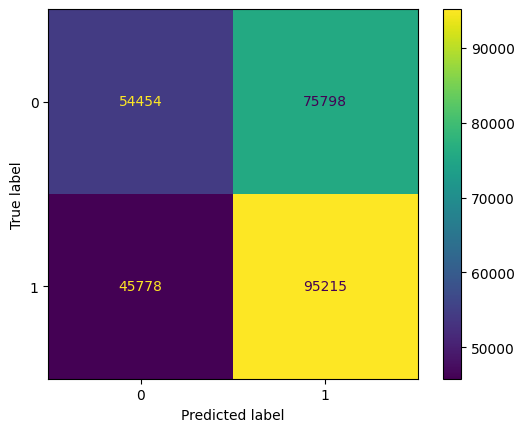

In [29]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(dt, X_test, y_test, values_format='')  
plt.show()

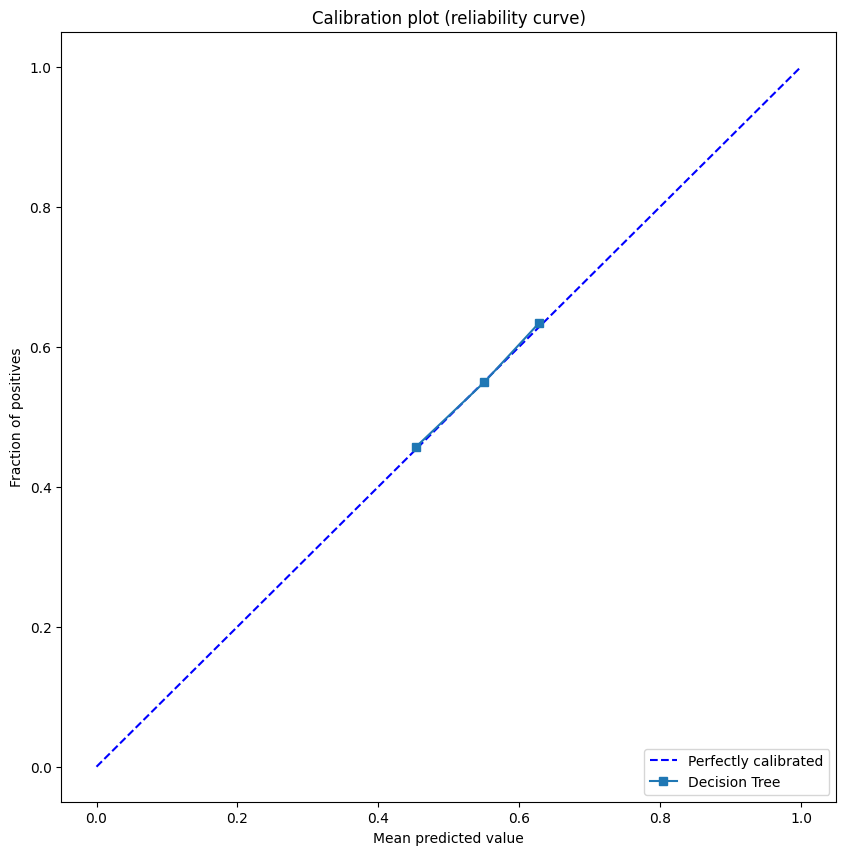

In [30]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_dt = dt.predict_proba(X_test)[:, 1]
fraction_of_positives_dt, mean_predicted_value_dt = calibration_curve(y_test, prob_pos_dt, n_bins=10)
ax.plot(mean_predicted_value_dt, fraction_of_positives_dt, "s-", label="%s" % ('Decision Tree'))

ax.legend(loc="lower right")
plt.show()

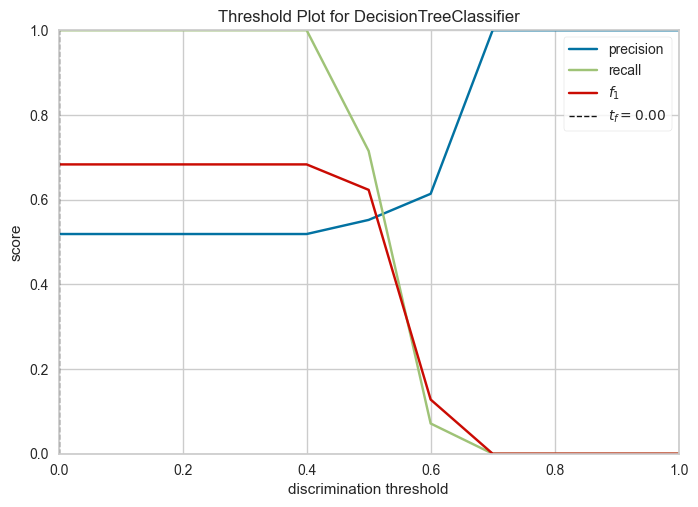

<AxesSubplot:title={'center':'Threshold Plot for DecisionTreeClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [31]:
from yellowbrick.classifier import DiscriminationThreshold
visualizer = DiscriminationThreshold(dt,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = 'queue_rate')
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

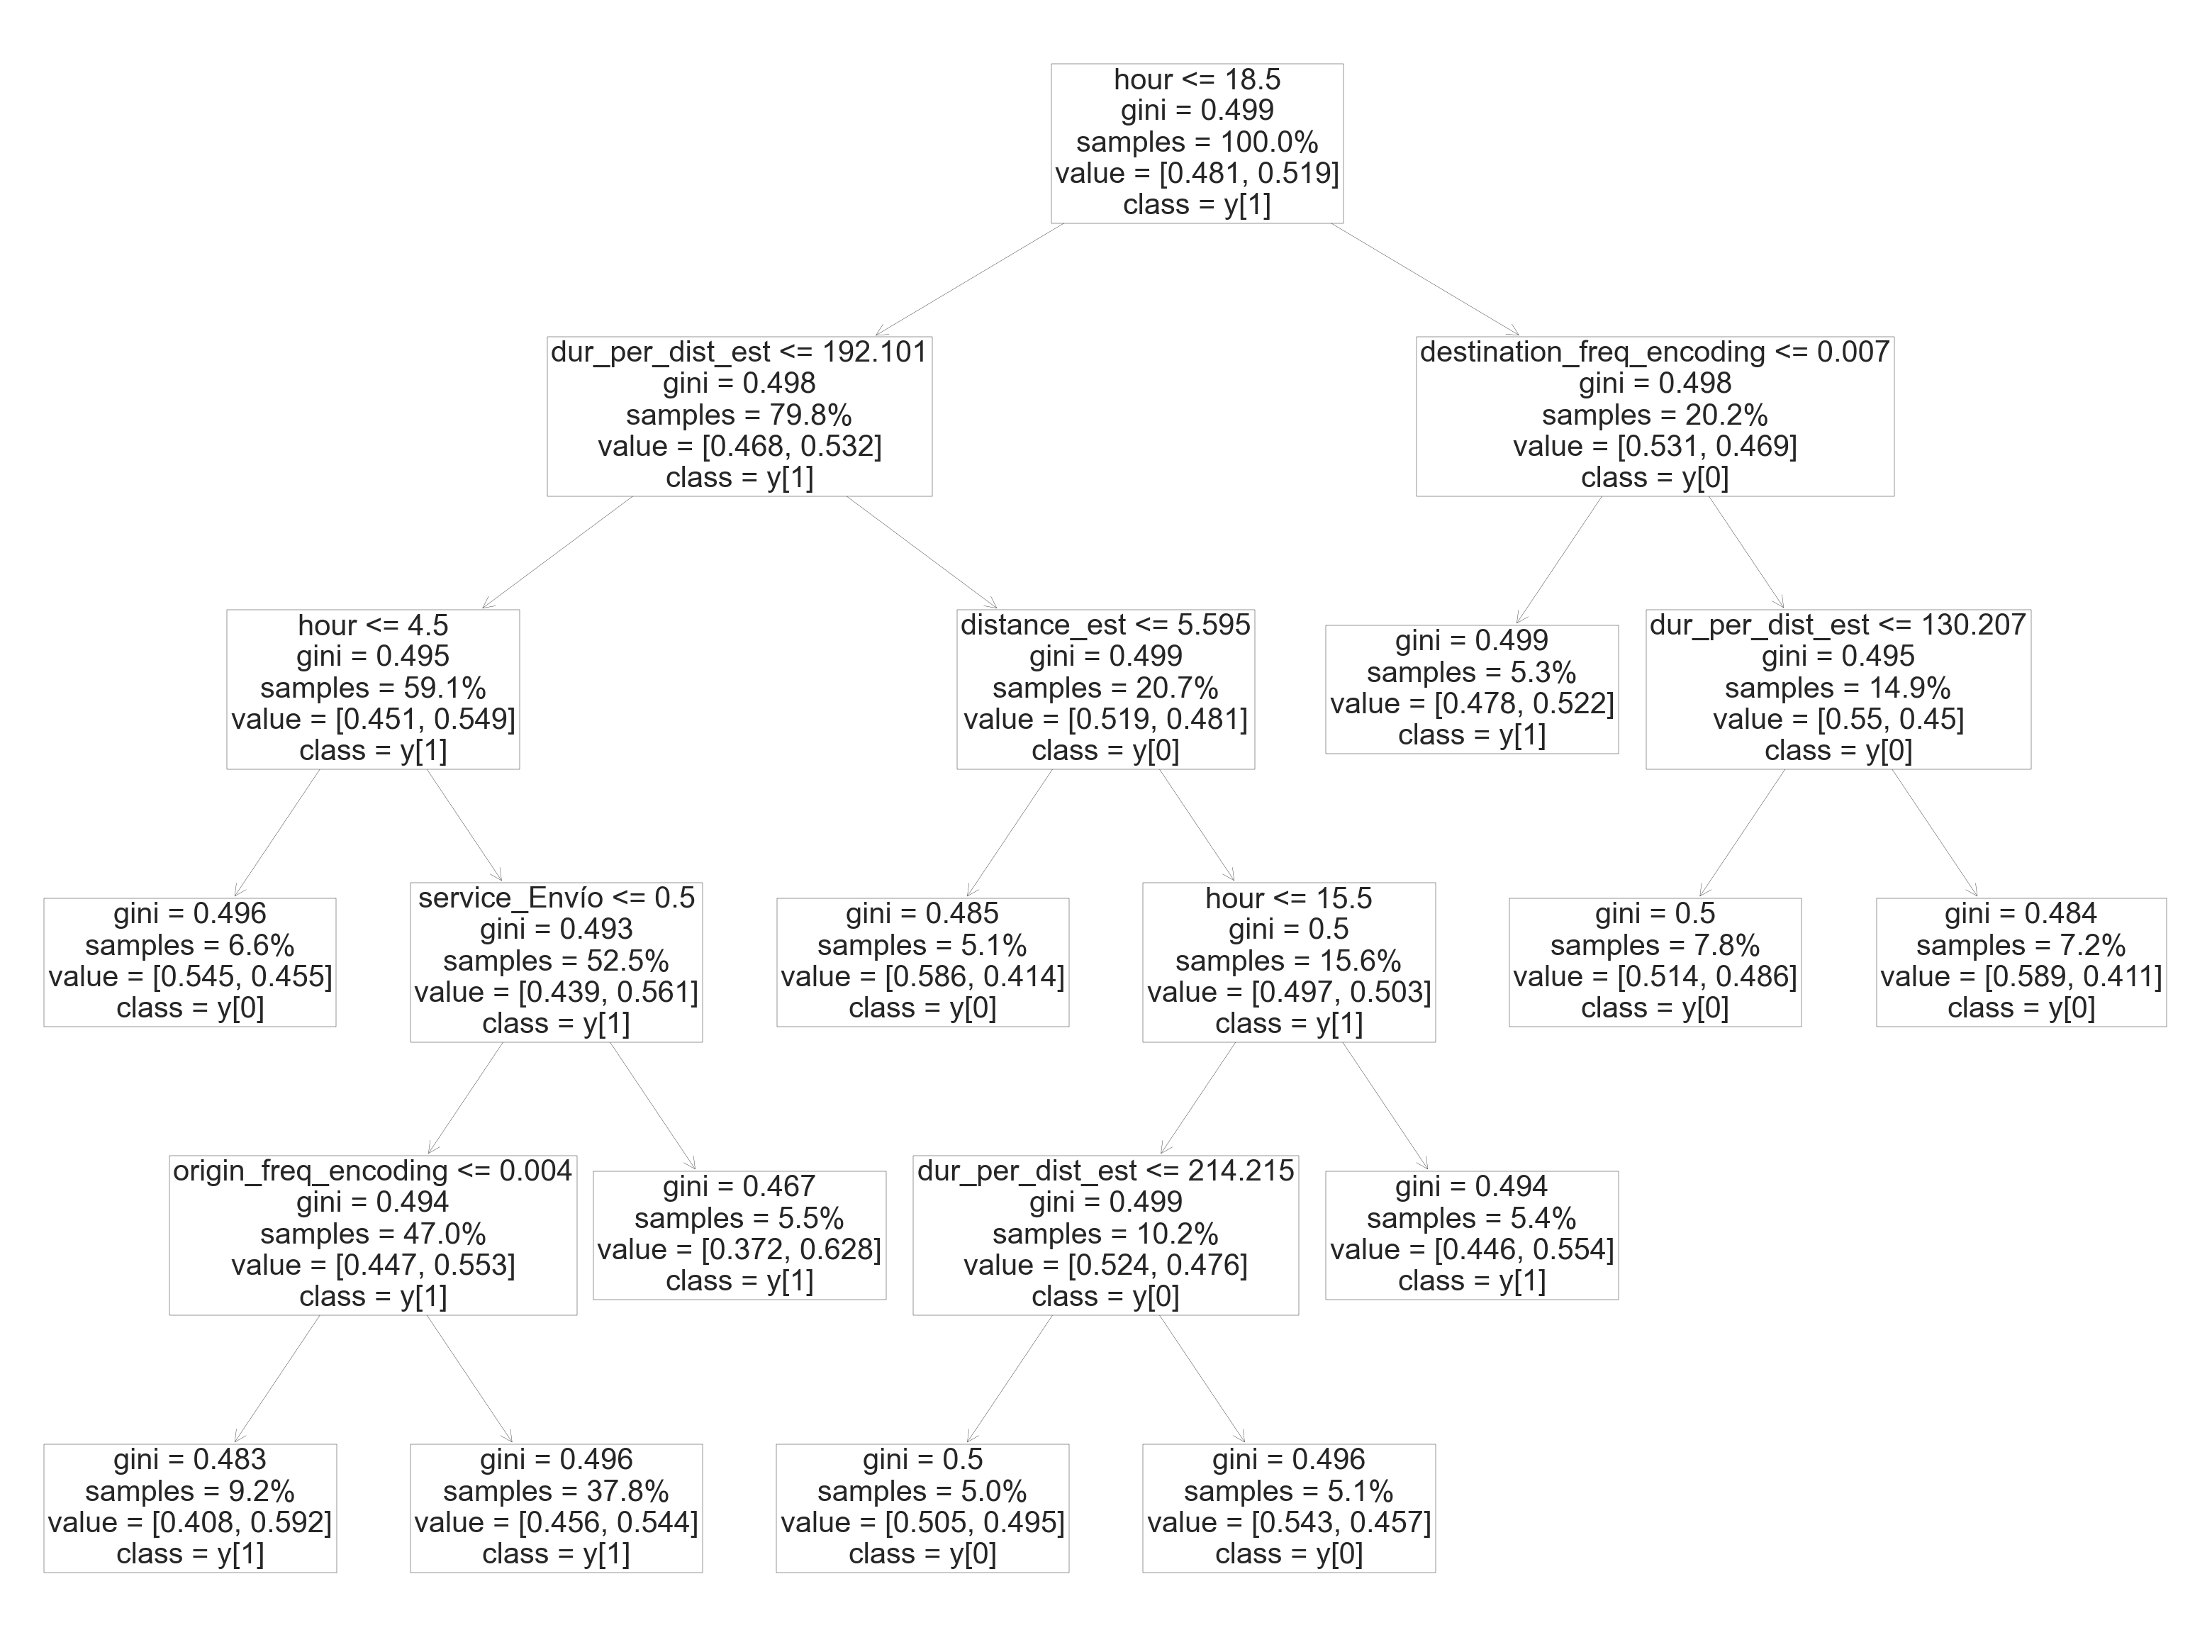

In [32]:
from sklearn import tree

plt.figure(figsize=(40,30))
tree.plot_tree(dt,max_depth=5,feature_names=X_test.columns,class_names=True,proportion=True,fontsize=30)
plt.show()

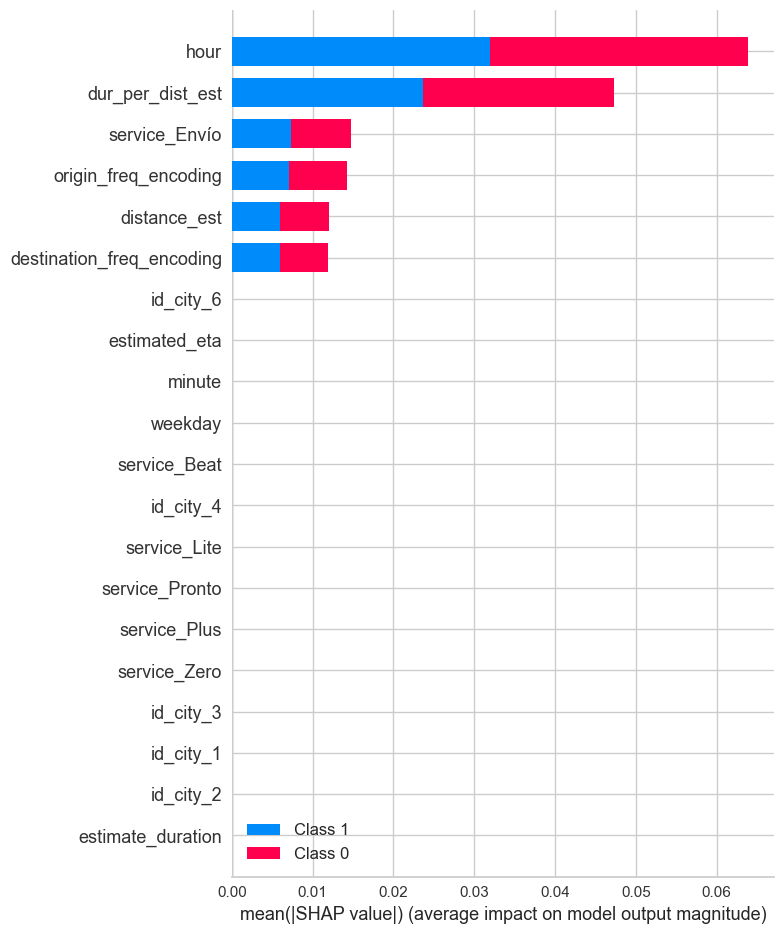

In [33]:
import shap
explainer = shap.TreeExplainer(dt)
shap_values_dt = explainer.shap_values(X_test)
shap.summary_plot(shap_values_dt, X_test, plot_type="bar")

In [34]:
y_pred = (dt.predict_proba(X_test)[:,1] >= 0.45)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.15      0.24    130252
           1       0.53      0.90      0.67    140993

    accuracy                           0.54    271245
   macro avg       0.56      0.52      0.45    271245
weighted avg       0.56      0.54      0.46    271245



In [35]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(n_estimators= 200,
                          learning_rate= 0.07,
                          random_state=23)
lgbm.fit(X_train, y_train)

y_pred=lgbm.predict(X_test)

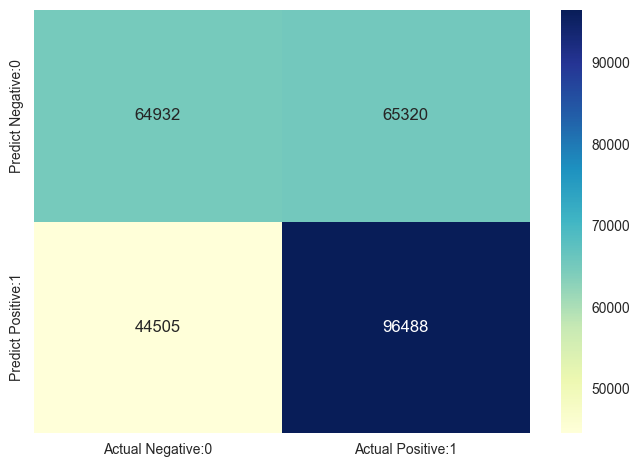

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0','Actual Positive:1'], 
                                  index=['Predict Negative:0','Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54    130252
           1       0.60      0.68      0.64    140993

    accuracy                           0.60    271245
   macro avg       0.59      0.59      0.59    271245
weighted avg       0.59      0.60      0.59    271245



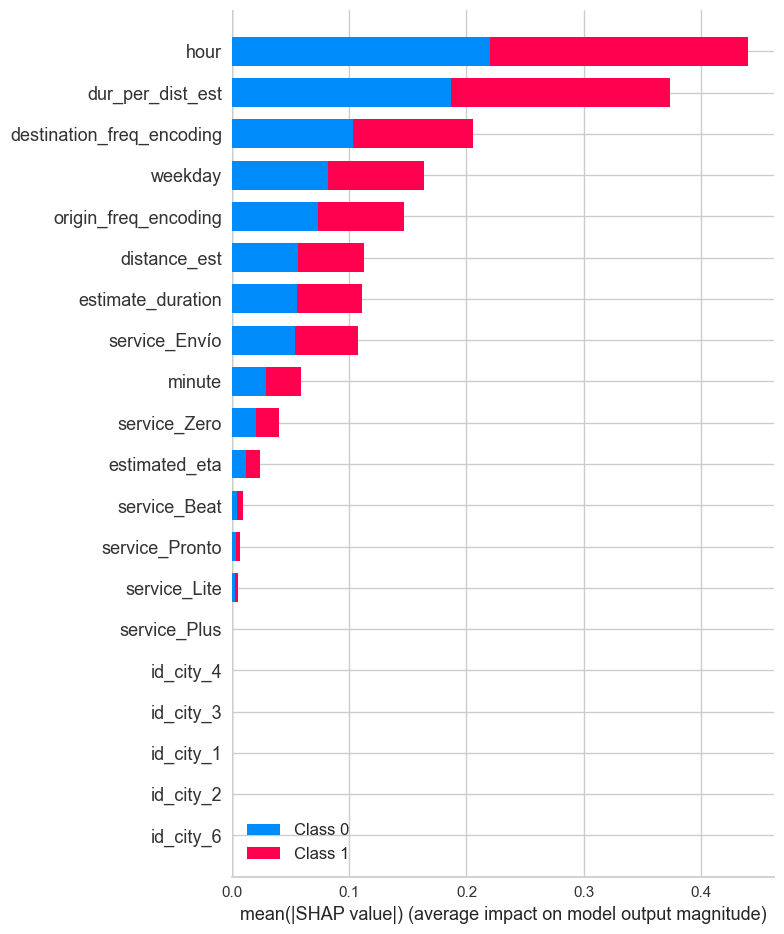

In [38]:
explainer = shap.TreeExplainer(lgbm)
shap_values_lgbm = explainer.shap_values(X_test)
shap.summary_plot(shap_values_lgbm, X_test, plot_type="bar")

In [39]:
lgbm._Booster.dump_model()["tree_info"]

[{'tree_index': 0,
  'num_leaves': 31,
  'num_cat': 0,
  'shrinkage': 1,
  'tree_structure': {'split_index': 0,
   'split_feature': 3,
   'split_gain': 1610.56005859375,
   'threshold': 18.500000000000004,
   'decision_type': '<=',
   'default_left': True,
   'missing_type': 'None',
   'internal_value': 0.0757697,
   'internal_weight': 0,
   'internal_count': 632904,
   'left_child': {'split_index': 1,
    'split_feature': 6,
    'split_gain': 1782.25,
    'threshold': 198.68785490310026,
    'decision_type': '<=',
    'default_left': True,
    'missing_type': 'None',
    'internal_value': 0.0793284,
    'internal_weight': 126041,
    'internal_count': 504886,
    'left_child': {'split_index': 2,
     'split_feature': 3,
     'split_gain': 1611.1700439453125,
     'threshold': 4.500000000000001,
     'decision_type': '<=',
     'default_left': True,
     'missing_type': 'None',
     'internal_value': 0.0837643,
     'internal_weight': 98163,
     'internal_count': 393216,
     'left_ch

In [40]:
lgbm.booster_.trees_to_dataframe().dropna().sort_values(by='tree_index',ascending=True)

tree_index  node_depth node_index left_child right_child parent_index  \
1               0           2       0-S1       0-S2        0-S3         0-S0   
57              0           5      0-S17      0-L13       0-L18        0-S12   
54              0           6      0-S20      0-L15       0-L21        0-S14   
51              0           6      0-S27      0-L12       0-L28        0-S14   
50              0           5      0-S14      0-S27       0-S20        0-S12   
...           ...         ...        ...        ...         ...          ...   
12141         199           3     199-S3     199-S5      199-S4       199-S2   
12140         199           2     199-S2     199-S3     199-S26       199-S0   
12193         199           6    199-S20    199-L20     199-L21      199-S19   
12162         199           7    199-S29     199-L7     199-L30      199-S15   
12196         199           5    199-S21    199-L19     199-L22      199-S18   

                   split_feature   split_gain    threshold decision_type  \
1               dur_per_dist_est  1782.250000   198.687855            <=   
57              dur_per_dist_est   296.429993   172.435075            <=   
54     destination_freq_encoding   280.545990     0.022821            <=   
51             estimate_duration   223.037003  1080.500000            <=   
50              dur_per_dist_est   391.045990   130.834936            <=   
...                          ...          ...          ...           ...   
12141  destination_freq_encoding    16.424900     0.009323            <=   
12140  destination_freq_encoding    32.090302     0.009438            <=   
12193                       hour    15.486800     6.500000            <=   
12162          estimate_duration    12.018100  1466.500000            <=   
12196                     minute    13.889900    49.500000            <=   

      missing_direction missing_type     value       weight   count  
1                  left         None  0.079328  126041.0000  504886  
57                 left         None  0.109055     925.9200    3709  
54                 left         None  0.042598   10325.7000   41362  
51                 left         None  0.061291   11694.7000   46846  
50                 left         None  0.052526   22020.4000   88208  
...                 ...          ...       ...          ...     ...  
12141              left         None  0.000211   44879.1000  187254  
12140              left         None  0.000537   46289.4000  193121  
12193              left         None -0.016477     871.9570    3600  
12162              left         None -0.005492    4551.9200   18775  
12196              left         None  0.019783      58.8471     254  

[5800 rows x 15 columns]

In [ ]:
coeff = {'id_city':[1,1,1,1,2,2,2,3,3,3,4,4,4,6,6],
         'service':['Beat','Envio','Lite','Zero','Beat','Envio','Lite','Beat','Envio','Lite','Beat','Envio','Lite','Beat','Lite'],
         'duration_coef_local':[119,1,108,840,124,0.1,111,172,0.1,162,90,2.75,84,124,114],
         'duration_coef_scaled_local':[621,644,565,0,660,714,596,613,676,537,798,785,751,436,388]}

In [ ]:
df_coeff = pd.DataFrame(coeff)
df_coeff